## Data Processing for Training Data

This file will go through data processing steps on the training data provided by the Kaggle Competition.

In [1]:
import numpy as np 
import pandas as pd 
import duckdb as db
conn = db.connect()
import matplotlib.pyplot as plt

Read in main table:

In [2]:
apps = conn.execute(
    """
    DROP TABLE IF EXISTS apps;
    CREATE TABLE apps AS
        SELECT * FROM read_csv_auto('data/application_train.csv');
    SELECT * FROM apps;
    """
).fetchdf()

In [3]:
apps.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


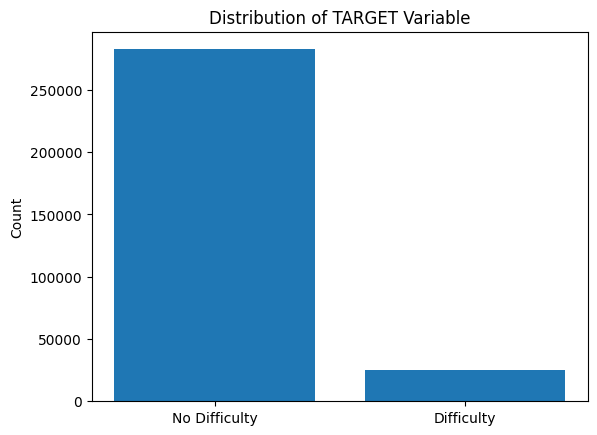

In [4]:
# plot value counts of TARGET column
target_counts = apps['TARGET'].value_counts()
plt.bar(target_counts.index, target_counts.values)
plt.xticks(target_counts.index, ['No Difficulty', 'Difficulty'])
plt.ylabel('Count')
plt.title('Distribution of TARGET Variable')
plt.show()

Very imbalanced, will have to consider oversampling or undersamping later


## Missing Value Handling

First, I'm going to try to fill in some of the missing entries that actually have meaning (e.g. missing a car-related variable means they don't own a car)

In [5]:
# when ext_source is missing, fill with mean of other ext_sources
ext_cols = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
apps["EXT_SOURCE_MEAN"] = apps[ext_cols].mean(axis=1, skipna=True) # the mean itself could be useful as well
apps["EXT_SOURCE_MEAN"] = apps["EXT_SOURCE_MEAN"].fillna(apps["EXT_SOURCE_MEAN"].median()) # edge case where all 3 are missing
for col in ext_cols:
    apps[col] = apps[col].fillna(apps["EXT_SOURCE_MEAN"]) # fill missing sources with mean of all sources

# missing car age means they don't have a car (there is already a flag for owning a car so no need to make a new one)
apps["OWN_CAR_AGE"] = apps["OWN_CAR_AGE"].fillna(0) # age = 0 = no car

# so many property-related columns where if missing, means they don't have that property
## current solution: a mean of proprerty-related columns and missingness proportion as features
property_cols = [c for c in apps.columns if "_AVG" in c or "_MEDI" in c or "_MODE" in c]
numeric_property_cols = apps[property_cols].select_dtypes(include=["number"]).columns
apps["PROPERTY_METRIC"] = apps[numeric_property_cols].mean(axis=1)
apps["PROPERTY_MISSING_PROP"] = apps[numeric_property_cols].isna().mean(axis=1)

# fill missing categorical property stuff with unknown (house type, wall material, etc.)
categorical_property_cols = apps[property_cols].select_dtypes(include=["object"]).columns
for col in categorical_property_cols:
    apps[col] = apps[col].fillna("UNKNOWN")

I either imputed or aggregated for all interesting features I could find with >50% missing values. So now I will drop any remaining.

In [6]:
apps = apps.loc[:, apps[apps['TARGET'] == 1].isnull().mean() < 0.5]
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 81 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

Now the data is pretty much full except for a few columns. 

- `AMT_REQ_CREDIT_BUREAU_{}`
    - 0 means no credit checks
    - missing is different, it means they don't have info from the bureau on credit checks
    - fill in with 0 but also add a flag for missing?
    - and calculate total credit checks for a simpler feature
- `OCCUPATION_TYPE`
    - missing could be anything: unemployed, retired, student, just unknown...
    - could be meaningful, so don't remove
    - impute with 'unknown'
- **Social circle columns**
    - Small % of missing values, but only one left with any real amount of missing
    - Missing means no social data for this client
    - Reasonably fill with 0?

In [7]:
# bureau credit checks: add missing flag, impute with 0, and sum total requests
bureau_cols = [
    "AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR"
]
apps["BUREAU_REQ_MISSING"] = apps[bureau_cols].isna().any(axis=1).astype(int)
apps[bureau_cols] = apps[bureau_cols].fillna(0)
apps["BUREAU_REQ_TOTAL"] = apps[bureau_cols].sum(axis=1, skipna=True)

# occupation type: impute with unknown
apps["OCCUPATION_TYPE"] = apps["OCCUPATION_TYPE"].fillna("Unknown")

# social circle columns: fill with 0
social_cols = [
    "OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE"
]
apps[social_cols] = apps[social_cols].fillna(0)
# calculate the default rates and totals for simple features
apps["SOCIAL_DEF_30_RATE"] = apps["DEF_30_CNT_SOCIAL_CIRCLE"] / (apps["OBS_30_CNT_SOCIAL_CIRCLE"] + 1e-5) # avoid div by 0
apps["SOCIAL_DEF_60_RATE"] = apps["DEF_60_CNT_SOCIAL_CIRCLE"] / (apps["OBS_60_CNT_SOCIAL_CIRCLE"] + 1e-5) # avoid div by 0
apps["SOCIAL_DEF_TOTAL"] = apps["DEF_30_CNT_SOCIAL_CIRCLE"] + apps["DEF_60_CNT_SOCIAL_CIRCLE"]
apps["SOCIAL_OBS_TOTAL"] = apps["OBS_30_CNT_SOCIAL_CIRCLE"] + apps["OBS_60_CNT_SOCIAL_CIRCLE"]

In [8]:
# Credit to Annuity Ratio
apps["credit_annuity_ratio"] = apps["AMT_CREDIT"] / apps["AMT_ANNUITY"]

# Credit to Goods Price Ratio
apps["credit_goods_price_ratio"] = apps["AMT_CREDIT"] / apps["AMT_GOODS_PRICE"]

# Credit Downpayment (how much they're putting down upfront)
apps["credit_downpayment"] = apps["AMT_GOODS_PRICE"] - apps["AMT_CREDIT"]

# Age in years (as integer)
apps["AGE_INT"] = (-apps["DAYS_BIRTH"] / 365).astype(int)

# Region Population Relative as categorical
apps["region_id"] = apps["REGION_POPULATION_RELATIVE"].astype(str)

# Handle any inf values that might have been created from division
apps = apps.replace([np.inf, -np.inf], np.nan)
apps["credit_annuity_ratio"] = apps["credit_annuity_ratio"].fillna(0)
apps["credit_goods_price_ratio"] = apps["credit_goods_price_ratio"].fillna(0)

conn.execute("DROP TABLE IF EXISTS apps")
conn.register('apps', apps)

There should be so few missing values now that I think we just go ahead and drop them. The column with the most missing values now is only ~200 out of ~300k, so dropping rows with missing values is pretty negligable. 

In [9]:
apps = apps.dropna()
apps.TARGET.value_counts()

TARGET
0    281451
1     24755
Name: count, dtype: int64

# Supplemental Data

Now, we can go through some of the other datasets and collect interesting information.

We have 3 categories of data:

1. Current applicant profile
    - what they requested, demographics, current income and asset stuff
    - `applicants.csv`: main dataset, already worked with above
2. External Credit History and Behavior
    - `bureau.csv`: loans with other lenders
    - `bureau_balance.csv`: monthly overview of how they have managed external debt
3. Internal Credit History and Behavior
    - `previous_application.csv`: past loans *applications* with Home Credit
    - `credit_card_balance.cvs`: monthly overview of credit cards with Home Credit
    - `POS_CASH_balance.csv`: monthly overview of point-of-sale and cash loans with Home Credit
    - `installments_payments.csv`: Payment history of previous loans from Home Credit


## External Credit

First, we will start with external credit. `bureau.csv` our connecting piece that links with our main table on `SK_ID_CURR` and with `bureau_balance.csv` on `SK_ID_BUREAU`. So, the process will be:

1. Summarize key monthly balance information down to 1 row per `SK_ID_BUREAU`
2. Join the two external credit tables
3. Summarize key information from external credit into 1 row per `SK_ID_CURR`
    - average credit status, worst credit status, proportion paid on time... etc
4. Join external credit summaries with main table, `applicants.csv`

Summarizing bureau balance:

In [10]:
# read in both tables (with some minor adjustments in place as needed)
conn.execute(
    """ 
    DROP TABLE IF EXISTS bureau;
    DROP TABLE IF EXISTS bureau_balance;
    CREATE TABLE bureau AS
        SELECT * FROM read_csv_auto('data/bureau.csv');
    CREATE TABLE bureau_balance AS
        WITH bb AS (
            SELECT *,
            CASE STATUS
                WHEN '0' THEN 0 -- on time
                WHEN '1' THEN 1
                WHEN '2' THEN 2
                WHEN '3' THEN 3
                WHEN '4' THEN 4
                WHEN '5' THEN 5
                ELSE NULL
            END AS status_num
        FROM read_csv_auto('data/bureau_balance.csv')
        WHERE STATUS IN ('0','1','2','3','4','5') -- drop Closed and Unknown statuses for now
        )
        -- compute recency per loan
        SELECT bb.*, 
            ROW_NUMBER() OVER (PARTITION BY SK_ID_BUREAU ORDER BY MONTHS_BALANCE DESC) AS recency
        FROM bb;
    """
)

# loan-level aggregation on bureau balance
## (summarize down to one row per loan from per month per loan)
conn.execute(
    """
    DROP TABLE IF EXISTS bureau_balance_agg;
    CREATE TABLE bureau_balance_agg AS
        SELECT 
            SK_ID_BUREAU,
            COUNT(*) AS num_months,
            AVG(status_num) AS avg_status,
            MAX(status_num) AS worst_status,
            CASE WHEN 
                SUM(CASE WHEN status_num > 0 THEN 1 ELSE 0 END) > 0 THEN 1 
                ELSE 0 END AS ever_late,
            COUNT(CASE WHEN status_num > 0 THEN 1 ELSE NULL END) AS num_late,
            AVG(CASE WHEN status_num > 0 THEN 1 ELSE 0 END) AS prop_late,
            MAX(CASE WHEN recency = 1 THEN status_num ELSE NULL END) AS most_recent_status
        FROM bureau_balance
        GROUP BY SK_ID_BUREAU
    """
)

Join with bureau and summarize to one loan per row:

In [11]:
# join bureau and bureau balance aggregation
conn.execute(
    """
    DROP TABLE IF EXISTS bureau_full;
    CREATE TABLE bureau_full AS
        SELECT 
            b.*,
            bb.num_months,
            bb.avg_status,
            bb.worst_status,
            bb.ever_late,
            bb.num_late,
            bb.prop_late,
            bb.most_recent_status,
            CASE WHEN bb.num_months IS NULL THEN 1 ELSE 0 END AS monthly_info_missing
        FROM bureau AS b
        LEFT JOIN bureau_balance_agg AS bb
            ON b.SK_ID_BUREAU = bb.SK_ID_BUREAU
    """
)

# summarize bureau_full to one row per applicant
conn.execute(
    """ 
    DROP TABLE IF EXISTS bureau_agg;
    CREATE TABLE bureau_agg AS
        WITH loan_ordering AS (
            SELECT *,
                ROW_NUMBER() OVER (PARTITION BY SK_ID_CURR ORDER BY DAYS_CREDIT_UPDATE DESC) AS update_order
            FROM bureau_full
        ), per_app AS (
            SELECT 
                SK_ID_CURR,

                -- coverage and counts
                COUNT(*) AS num_loans,
                COUNT(CASE WHEN CREDIT_ACTIVE = 'Active' THEN 1 ELSE NULL END) AS num_active_loans,
                COUNT(CASE WHEN CREDIT_ACTIVE = 'Closed' THEN 1 ELSE NULL END) AS num_closed_loans,
                COUNT(CASE WHEN monthly_info_missing = 1 THEN 1 ELSE NULL END) AS num_loans_missing_info,
                
                -- overall payment behavior
                MAX(COAlESCE(worst_status, 0)) AS worst_status,
                SUM(COALESCE(avg_status, 0) * COALESCE(num_months, 0)) AS sum_avg_status,
                SUM(COALESCE(prop_late, 0) * COALESCE(num_months, 0)) AS sum_prop_late,
                SUM(COALESCE(num_months, 0)) AS total_months,
                SUM(COALESCE(num_late, 0)) AS total_late,
                SUM(CASE WHEN COALESCE(ever_late, 0) = 1 THEN 1 ELSE 0 END) AS num_loans_ever_late,

                -- exposure
                SUM(AMT_CREDIT_SUM) AS total_credit_amount,
                SUM(AMT_CREDIT_SUM_DEBT) AS total_credit_debt,
                SUM(AMT_CREDIT_SUM_OVERDUE) AS total_credit_overdue,
                SUM(AMT_CREDIT_SUM_LIMIT) AS total_credit_limit,
                AVG(AMT_CREDIT_SUM) AS avg_credit_amount,
                AVG(AMT_CREDIT_SUM_DEBT) AS avg_credit_debt,
                SUM(CNT_CREDIT_PROLONG) AS total_credit_prolongs,
                AVG(CNT_CREDIT_PROLONG) AS avg_credit_prolongs,
                AVG(AMT_ANNUITY) AS avg_credit_annuity,
                AVG(
                    CASE WHEN AMT_CREDIT_SUM IS NOT NULL AND AMT_CREDIT_SUM <> 0
                        THEN AMT_CREDIT_SUM_DEBT / AMT_CREDIT_SUM END
                )   AS avg_credit_debt_ratio,
                MAX(
                    CASE WHEN AMT_CREDIT_SUM IS NOT NULL AND AMT_CREDIT_SUM <> 0
                        THEN AMT_CREDIT_SUM_OVERDUE / AMT_CREDIT_SUM END
                )   AS worst_credit_overdue_ratio,
                
                -- recency
                MAX(DAYS_CREDIT_UPDATE) AS most_recent_update,
                MAX(DAYS_CREDIT) AS most_recent_loan,
                MAX(CASE WHEN update_order = 1 THEN most_recent_status END) AS most_recent_loan_status,
                MAX(CASE WHEN update_order = 1 THEN CREDIT_ACTIVE END) AS most_recent_loan_active,
                MAX(CASE WHEN update_order = 1 THEN CREDIT_TYPE END) AS most_recent_loan_type,

                -- DAYS_CREDIT feature engineering
                AVG(DAYS_CREDIT) AS DAYS_CREDIT_mean,
                MAX(CASE WHEN CREDIT_ACTIVE = 'Active' THEN DAYS_CREDIT END) AS last_active_DAYS_CREDIT

            FROM loan_ordering
            GROUP BY SK_ID_CURR
        ), final_agg AS (
            SELECT 
                per_app.*,
                
                -- ratios
                CASE WHEN num_loans > 0 THEN 
                    num_active_loans * 1.0 / num_loans 
                ELSE 0 END AS active_loan_ratio,
                CASE WHEN num_loans > 0 THEN
                    num_loans_ever_late * 1.0 / num_loans 
                ELSE 0 END AS ever_late_loan_ratio,
                CASE WHEN total_months > 0 THEN
                    sum_avg_status * 1.0 / total_months
                ELSE 0 END AS avg_status,
                CASE WHEN total_months > 0 THEN
                    sum_prop_late * 1.0 / total_months
                ELSE 0 END AS prop_late,
                
            FROM per_app
        )
        SELECT * FROM final_agg;
    """
)

Join all bureau stuff with current applications:

In [12]:
# join bureau_agg back to apps

# add _external suffix to avoid name clashes with internal stuff
cols_ext = conn.execute("PRAGMA table_info('bureau_agg')").fetchdf()["name"].tolist()
cols_ext = [c for c in cols_ext if c != "SK_ID_CURR"]
ext_cols_sql = ", ".join([f"b.{c} AS {c}_external" for c in cols_ext])

# join
apps_bureau = conn.execute(f"""
DROP TABLE IF EXISTS apps_bureau;
CREATE TABLE apps_bureau AS
SELECT
    a.*,
    {ext_cols_sql},
    CASE WHEN b.SK_ID_CURR IS NULL THEN 1 ELSE 0 END AS no_bureau_history_external
FROM apps AS a
LEFT JOIN bureau_agg AS b USING (SK_ID_CURR);
SELECT * FROM apps_bureau LIMIT 10;
""").fetchdf()


In [13]:
apps_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,most_recent_loan_status_external,most_recent_loan_active_external,most_recent_loan_type_external,DAYS_CREDIT_mean_external,last_active_DAYS_CREDIT_external,active_loan_ratio_external,ever_late_loan_ratio_external,avg_status_external,prop_late_external,no_bureau_history_external
0,455906,0,Cash loans,F,N,N,0,130500.0,545040.0,26640.0,...,0.0,Active,Consumer credit,-1500.333333,-89.0,0.166667,0.000000,0.000000,0.000000,0
1,455910,0,Cash loans,F,N,Y,0,85500.0,225000.0,12334.5,...,0.0,Closed,Consumer credit,-686.666667,NaN,0.000000,0.666667,0.033898,0.033898,0
2,455911,0,Cash loans,F,N,Y,0,112500.0,536917.5,19413.0,...,NaN,Active,Credit card,-1003.333333,-676.0,0.333333,0.000000,0.000000,0.000000,0
3,455912,0,Cash loans,F,N,Y,0,108000.0,291384.0,20853.0,...,NaN,Closed,Consumer credit,-2307.000000,NaN,0.000000,0.000000,0.000000,0.000000,0
4,455916,0,Cash loans,F,N,Y,0,315000.0,646920.0,20997.0,...,NaN,Active,Credit card,-821.142857,-159.0,0.571429,0.000000,0.000000,0.000000,0


## Internal Credit

These tables are `POS_CASH_balance.csv`, `credit_card_balance.csv`, `previous_application.csv`, and `installments_payments.csv`. Overall, these tables act pretty similar to the bureau tables, so it will be a similar process of aggregation until we can finally combine with the applications table. 

Starting with the two monthly tables: `POS_CASH_balance.csv` and `credit_card_balance.csv`. This should resemble `bureau_balance.csv`

In [14]:
# aggregate pos_cash_balance to one row per previous loan per applicant (still one step away)
conn.execute(
    """ 
    DROP TABLE IF EXISTS pos_cash_agg;
    CREATE TABLE pos_cash_agg AS
    WITH ordered AS (
        SELECT *,
            ROW_NUMBER() OVER (PARTITION BY SK_ID_PREV ORDER BY MONTHS_BALANCE DESC) AS recency
        FROM read_csv_auto('data/POS_CASH_balance.csv')
    )
    SELECT 
        SK_ID_PREV,
        ANY_VALUE(SK_ID_CURR) AS SK_ID_CURR,
        COUNT(*) AS num_months,
        AVG(COALESCE(SK_DPD_DEF, SK_DPD)) AS avg_dpd, -- dpd is days past due
        MAX(COALESCE(SK_DPD_DEF, SK_DPD)) AS worst_dpd,
        SUM(CASE WHEN COALESCE(SK_DPD_DEF, SK_DPD) > 0 THEN 1 ELSE 0 END) AS num_late_months,
        CASE WHEN COUNT(*) > 0 
            THEN SUM(CASE WHEN COALESCE(SK_DPD_DEF, SK_DPD, 0) > 0 THEN 1 ELSE 0 END) * 1.0 
                / COUNT(*) 
            END AS prop_late_months,
        MAX(CASE WHEN recency = 1 THEN COALESCE(SK_DPD_DEF, SK_DPD) END) AS most_recent_dpd,
        MAX(CASE WHEN recency = 1 THEN NAME_CONTRACT_STATUS ELSE NULL END) AS most_recent_status
    FROM ordered
    GROUP BY SK_ID_PREV;
    """
)

# aggregate credit_card_balance to same level (want the features to match mostly)
conn.execute(
    """ 
    DROP TABLE IF EXISTS credit_card_agg;
    CREATE TABLE credit_card_agg AS
    WITH cc AS (
        SELECT *,
            CASE
                WHEN AMT_CREDIT_LIMIT_ACTUAL IS NOT NULL AND AMT_CREDIT_LIMIT_ACTUAL <> 0
                    THEN AMT_BALANCE * 1.0 / AMT_CREDIT_LIMIT_ACTUAL
            END AS usage,
            CASE
                WHEN AMT_INST_MIN_REGULARITY IS NOT NULL AND AMT_INST_MIN_REGULARITY <> 0
                    THEN AMT_PAYMENT_TOTAL_CURRENT * 1.0 / AMT_INST_MIN_REGULARITY
            END AS pay_ratio,
            ROW_NUMBER() OVER (PARTITION BY SK_ID_PREV ORDER BY MONTHS_BALANCE DESC) AS recency
        FROM read_csv_auto('data/credit_card_balance.csv')
    )
    SELECT SK_ID_PREV, ANY_VALUE(SK_ID_CURR) AS SK_ID_CURR,

        -- match similar features as pos_cash_agg
        COUNT(*) AS num_months,
         AVG(COALESCE(SK_DPD_DEF, SK_DPD)) AS avg_dpd, -- dpd is days past due
        MAX(COALESCE(SK_DPD_DEF, SK_DPD)) AS worst_dpd,
        SUM(CASE WHEN COALESCE(SK_DPD_DEF, SK_DPD) > 0 THEN 1 ELSE 0 END) AS num_late_months,
        CASE WHEN COUNT(*) > 0 
            THEN SUM(CASE WHEN COALESCE(SK_DPD_DEF, SK_DPD, 0) > 0 THEN 1 ELSE 0 END) * 1.0 
                / COUNT(*) 
            END AS prop_late_months,
        MAX(CASE WHEN recency = 1 THEN COALESCE(SK_DPD_DEF, SK_DPD) END) AS most_recent_dpd,
        MAX(CASE WHEN recency = 1 THEN NAME_CONTRACT_STATUS ELSE NULL END) AS most_recent_status,

        -- a couple new features
        AVG(usage) AS avg_usage,
        MAX(usage) AS max_usage,
        AVG(pay_ratio) AS avg_pay_ratio
        
    FROM cc
    GROUP BY SK_ID_PREV;
    """
)

# union the two aggregations to get all loans for each applicant
conn.execute(
    """ 
DROP TABLE IF EXISTS previous_loans_agg;
CREATE TABLE previous_loans_agg AS
SELECT SK_ID_PREV, SK_ID_CURR, num_months, avg_dpd, worst_dpd, num_late_months, prop_late_months, most_recent_dpd, most_recent_status,
    NULL::DOUBLE AS avg_usage,
    NULL::DOUBLE AS max_usage,
    NULL::DOUBLE AS avg_pay_ratio,
    'POS' AS source
FROM pos_cash_agg

UNION ALL

SELECT SK_ID_PREV, SK_ID_CURR, num_months, avg_dpd, worst_dpd, num_late_months, prop_late_months, most_recent_dpd, most_recent_status,
    avg_usage, max_usage, avg_pay_ratio,
    'CC' AS source
FROM credit_card_agg;
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Now aggregate these loans to applicatant level:

In [15]:
# now aggregate to one row per applicant
conn.execute(
    """
    DROP TABLE IF EXISTS previous_loans_final_agg;
    CREATE TABLE previous_loans_final_agg AS
    WITH per_app AS (
        SELECT 
            SK_ID_CURR,

            -- counts and totals
            COUNT(*)                                                     AS num_prev_loans,
            COUNT(CASE WHEN source = 'POS' THEN 1 ELSE NULL END)         AS num_pos_loans,
            COUNT(CASE WHEN source = 'CC'  THEN 1 ELSE NULL END)         AS num_cc_loans,
            SUM(num_months)                                              AS total_months,
            SUM(num_late_months)                                         AS total_late_months,
            SUM(CASE WHEN prop_late_months IS NOT NULL THEN 1 ELSE 0 END) AS loans_with_info,

            -- months-weighted sums for dpd/utilization (averages later)
            SUM(avg_dpd * num_months)                                    AS sum_avg_dpd_weighted,
            SUM(CASE WHEN source = 'CC' THEN COALESCE(avg_usage,0) * num_months END) AS sum_cc_usage_weighted,
            SUM(CASE WHEN source = 'CC' THEN num_months END)             AS sum_cc_months,

            -- severity snapshots
            MAX(worst_dpd)                                               AS overall_worst_dpd,
            MAX(most_recent_dpd)                                         AS recent_worst_dpd,

            -- credit card extras
            AVG(CASE WHEN source = 'CC' THEN avg_pay_ratio END)          AS avg_cc_pay_ratio,
            MAX(CASE WHEN source = 'CC' THEN max_usage END)              AS max_cc_usage

        FROM previous_loans_agg
        GROUP BY SK_ID_CURR
    ),
    final AS (
        SELECT
            SK_ID_CURR,
            num_prev_loans,
            num_pos_loans,
            num_cc_loans,
            total_months,
            total_late_months,
            loans_with_info,
            overall_worst_dpd,
            recent_worst_dpd,
            max_cc_usage,

            -- months-weighted pooled means (NULL if no months)
            CASE WHEN total_months > 0
                THEN sum_avg_dpd_weighted * 1.0 / total_months
            END AS avg_dpd,
            CASE WHEN total_months > 0
                THEN total_late_months * 1.0 / total_months
            END AS prop_late,

            -- CC utilization pooled by CC-months only
            CASE WHEN COALESCE(sum_cc_months,0) > 0
                THEN sum_cc_usage_weighted * 1.0 / sum_cc_months
            END AS avg_cc_usage,

            avg_cc_pay_ratio
        FROM per_app
    )
    SELECT * FROM final;

    """
)

Now aggregating `installments_payments.csv`... each row is one payment per previous application per applicant, so it will take two aggregation steps.  

In [16]:
# per loan aggregation
conn.execute(
    """ 
    DROP TABLE IF EXISTS payments_agg;
    CREATE TABLE payments_agg AS
        WITH ip AS (
            SELECT
                *,
                (DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT) AS days_diff,
                (AMT_PAYMENT - AMT_INSTALMENT) AS payment_diff
            FROM read_csv_auto('data/installments_payments.csv')
        )
        SELECT
            SK_ID_PREV,
            ANY_VALUE(SK_ID_CURR) AS SK_ID_CURR,
            COUNT(*) AS num_payments,

            -- lateness / earliness
            AVG(days_diff) AS avg_days_diff,
            MAX(days_diff) AS max_days_diff, -- worst late
            MIN(days_diff) AS min_days_diff, -- negative = paid early
            SUM(CASE WHEN days_diff > 0 THEN 1 ELSE 0 END) AS num_late_payments,
            SUM(CASE WHEN days_diff < 0 THEN 1 ELSE 0 END) AS num_early_payments,
            CASE WHEN COUNT(*) > 0
                THEN SUM(CASE WHEN days_diff > 0 THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
            END AS prop_late_payments,
            CASE WHEN COUNT(*) > 0
                THEN SUM(CASE WHEN days_diff < 0 THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
            END AS prop_early_payments,

            -- amounts/rates
            SUM(AMT_INSTALMENT) AS sum_due,
            SUM(AMT_PAYMENT) AS sum_paid,
            CASE WHEN SUM(AMT_INSTALMENT) > 0
                THEN SUM(AMT_PAYMENT) * 1.0 / SUM(AMT_INSTALMENT)
            END AS prop_paid,

            -- NEW: Payment difference for recent installments (DAYS_INSTALMENT > -1000)
            AVG(CASE WHEN DAYS_INSTALMENT > -1000 THEN payment_diff END) AS installment_payment_ratio_1000_mean,
            
            -- NEW: Maximum installment amount
            MAX(AMT_INSTALMENT) AS max_instalment

        FROM ip
        GROUP BY SK_ID_PREV;
    """
)

# per applicant aggregation
conn.execute(
""" 
    DROP TABLE IF EXISTS final_inst_agg;
    CREATE TABLE final_inst_agg AS
        WITH per_app AS (
            SELECT
                SK_ID_CURR,
                COUNT(*) AS inst_num_loans,
                SUM(num_payments) AS inst_total_payments,

                -- weighted pools (weights = num_payments)
                SUM(avg_days_diff * num_payments) AS sum_avg_days,
                SUM(num_payments) AS sum_weights,

                -- total late/early for exact pooled proportions
                SUM(num_late_payments) AS inst_total_late_payments,
                SUM(num_early_payments) AS inst_total_early_payments,

                -- extremes
                MAX(max_days_diff) AS inst_max_days_diff,
                MIN(min_days_diff) AS inst_min_days_diff,

                -- money & pay rate (portfolio-level)
                SUM(sum_due) AS inst_sum_due,
                SUM(sum_paid) AS inst_sum_paid,

                -- Some more new features below
                -- Weight by number of payments per loan, then take mean across loans
                SUM(COALESCE(installment_payment_ratio_1000_mean, 0) * num_payments) AS sum_payment_diff_weighted,
                SUM(CASE WHEN installment_payment_ratio_1000_mean IS NOT NULL THEN num_payments ELSE 0 END) AS sum_payment_diff_weights,
            
                -- Maximum installment across all loans
                MAX(max_instalment) AS inst_max_instalment

            FROM payments_agg
            GROUP BY SK_ID_CURR
        )
        SELECT
            SK_ID_CURR,
            inst_num_loans,
            inst_total_payments,
            inst_max_days_diff,
            inst_min_days_diff,
            inst_sum_due,
            inst_sum_paid,

            -- weighted mean days late/early (null if no payments)
            CASE WHEN sum_weights > 0
                THEN sum_avg_days * 1.0 / sum_weights
            END AS inst_avg_days_diff,

            -- proportions early/late
            CASE WHEN inst_total_payments > 0
                THEN inst_total_late_payments * 1.0 / inst_total_payments
            END AS inst_prop_late_payments,
            CASE WHEN inst_total_payments > 0
                THEN inst_total_early_payments * 1.0 / inst_total_payments
            END AS inst_prop_early_payments,

            -- pay rate
            CASE WHEN inst_sum_due > 0
                THEN inst_sum_paid * 1.0 / inst_sum_due
            END AS inst_pay_rate,

            -- Mean payment difference (weighted by number of payments)
            CASE WHEN sum_payment_diff_weights > 0
                THEN sum_payment_diff_weighted * 1.0 / sum_payment_diff_weights
            END AS installment_payment_ratio_1000_mean_mean,

            -- NEW: Maximum installment
            inst_max_instalment

        FROM per_app;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Now aggregating `previous_applications.csv`... this is one row per previous application per applicant so it will take one aggregation step.

In [17]:
# aggregate previous applications
conn.execute(
""" 
    DROP TABLE IF EXISTS prev_apps_agg;
    CREATE TABLE prev_apps_agg AS

        WITH prev_apps AS (
            SELECT * FROM read_csv_auto('data/previous_application.csv')
        ),

        ordered AS (
            SELECT
                *,
                ROW_NUMBER() OVER (
                    PARTITION BY SK_ID_CURR
                    ORDER BY DAYS_DECISION DESC -- least negative / most recent
                ) AS rn
            FROM prev_apps
        )

        SELECT
                SK_ID_CURR,

                -- counts by status
                COUNT(*) AS prev_num_apps,
                SUM(CASE WHEN NAME_CONTRACT_STATUS = 'Approved' THEN 1 ELSE 0 END) AS prev_num_approved,
                SUM(CASE WHEN NAME_CONTRACT_STATUS = 'Refused' THEN 1 ELSE 0 END) AS prev_num_refused,
                SUM(CASE WHEN NAME_CONTRACT_STATUS = 'Canceled' THEN 1 ELSE 0 END) AS prev_num_canceled,
                SUM(CASE WHEN NAME_CONTRACT_STATUS = 'Unused offer' THEN 1 ELSE 0 END) AS prev_num_unused_offer,

                -- approval rate
                CASE WHEN COUNT(*) > 0
                    THEN SUM(CASE WHEN NAME_CONTRACT_STATUS = 'Approved' THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
                END AS prev_approval_rate,

                -- recency and last decision status
                -MAX(DAYS_DECISION) AS prev_days_since_last_decision,
                MAX(CASE WHEN rn = 1 THEN NAME_CONTRACT_STATUS END) AS prev_last_decision_status,

                -- amounts and ratios
                AVG(AMT_APPLICATION) AS prev_mean_amt_application,
                AVG(AMT_CREDIT) AS prev_mean_amt_credit,
                AVG(AMT_ANNUITY) AS prev_mean_amt_annuity,
                AVG(CNT_PAYMENT) AS prev_mean_cnt_payment,
                AVG(CASE WHEN AMT_APPLICATION IS NOT NULL AND AMT_APPLICATION <> 0
                        THEN AMT_CREDIT * 1.0 / AMT_APPLICATION END) AS prev_mean_credit_to_application_ratio,

                -- product/portfolio mix
                SUM(CASE WHEN NAME_PORTFOLIO = 'Cash' THEN 1 ELSE 0 END) AS prev_num_portfolio_cash,
                SUM(CASE WHEN NAME_PORTFOLIO = 'POS'  THEN 1 ELSE 0 END) AS prev_num_portfolio_pos,
                SUM(CASE WHEN NAME_PORTFOLIO = 'XNA'  THEN 1 ELSE 0 END) AS prev_num_portfolio_xna,
                SUM(CASE WHEN NAME_PORTFOLIO = 'Cards'  THEN 1 ELSE 0 END) AS prev_num_portfolio_cards,
                SUM(CASE WHEN NAME_PORTFOLIO = 'Cars'  THEN 1 ELSE 0 END) AS prev_num_portfolio_cars,
                CASE WHEN COUNT(*) > 0
                    THEN SUM(CASE WHEN NAME_PORTFOLIO = 'Cash' THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
                END AS prev_prop_portfolio_cash,
                CASE WHEN COUNT(*) > 0
                    THEN SUM(CASE WHEN NAME_PORTFOLIO = 'POS'  THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
                END AS prev_prop_portfolio_pos,
                CASE WHEN COUNT(*) > 0
                    THEN SUM(CASE WHEN NAME_PORTFOLIO = 'XNA'  THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
                END AS prev_prop_portfolio_xna,
                CASE WHEN COUNT(*) > 0
                    THEN SUM(CASE WHEN NAME_PORTFOLIO = 'Cards'  THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
                END AS prev_prop_portfolio_cards,
                CASE WHEN COUNT(*) > 0
                    THEN SUM(CASE WHEN NAME_PORTFOLIO = 'Cars'  THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
                END AS prev_prop_portfolio_cars

            FROM ordered
            GROUP BY SK_ID_CURR
"""
)

Combine all internal information into one table:

In [18]:
# combine all internal tables
conn.execute(
    """ 
    DROP TABLE IF EXISTS internal_all;
    CREATE TABLE internal_all AS
    SELECT
        pl.*,
        ip.* EXCLUDE (SK_ID_CURR),
        pa.* EXCLUDE (SK_ID_CURR)
    FROM previous_loans_final_agg AS pl
    FULL OUTER JOIN final_inst_agg  AS ip USING (SK_ID_CURR)
    FULL OUTER JOIN prev_apps_agg   AS pa USING (SK_ID_CURR);
    """
)

Join with apps+bureau table:

In [19]:
# add internal suffix
cols_internal = conn.execute("PRAGMA table_info('internal_all')").fetchdf()["name"].tolist()
cols_internal = [c for c in cols_internal if c != "SK_ID_CURR"]
internal_cols_sql = ", ".join([f"i.{c} AS {c}_internal" for c in cols_internal])

# join
apps_with_internal = conn.execute(f"""
DROP TABLE IF EXISTS apps_with_internal;
CREATE TABLE apps_with_internal AS
SELECT
  a.*,
  {internal_cols_sql},
  CASE WHEN i.SK_ID_CURR IS NULL THEN 1 ELSE 0 END AS no_internal_history
FROM apps_bureau a
LEFT JOIN internal_all i USING (SK_ID_CURR);

SELECT * FROM apps_with_internal LIMIT 10;
""").fetchdf()

Combine some of the internal and external stuff where possible for overall stats:

In [20]:
apps_all_background = conn.execute(
""" 
    DROP TABLE IF EXISTS apps_all_background;
    CREATE TABLE apps_all_background AS

        SELECT
            *,

            -- totals
            (COALESCE(num_loans_external,0) + COALESCE(num_prev_loans_internal,0)) AS total_loans_all,
            (COALESCE(total_months_external,0) + COALESCE(total_months_internal,0)) AS total_months_all,
            (COALESCE(total_late_external,0) + COALESCE(total_late_months_internal,0)) AS total_late_months_all,

            -- external + internal combined proportions
            CASE
                WHEN COALESCE(total_months_external,0) + COALESCE(total_months_internal,0) > 0 THEN
                    (
                    COALESCE(prop_late_external,0) * COALESCE(total_months_external,0) +
                    COALESCE(prop_late_internal,0) * COALESCE(total_months_internal,0)
                    ) / (COALESCE(total_months_external,0) + COALESCE(total_months_internal,0))
                END AS prop_late_all,

            -- recent lateness overall
            CASE
                WHEN COALESCE(most_recent_loan_status_external,0) > 0
                    OR COALESCE(recent_worst_dpd_internal,0) > 0
                    OR COALESCE(inst_max_days_diff_internal,0) > 0
                THEN 1 ELSE 0
                END AS recent_any_late_all,

            -- has any credit history at all
            CASE
                WHEN COALESCE(no_bureau_history_external,0)=1
                AND COALESCE(no_internal_history,0)=1
                THEN 0 ELSE 1
                END AS has_any_history_all
        FROM apps_with_internal;
    
    SELECT * FROM apps_all_background;
"""
).fetchdf()

In [21]:
apps_all_background.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,prev_prop_portfolio_xna_internal,prev_prop_portfolio_cards_internal,prev_prop_portfolio_cars_internal,no_internal_history,total_loans_all,total_months_all,total_late_months_all,prop_late_all,recent_any_late_all,has_any_history_all
0,384638,0,Cash loans,M,Y,N,0,180000.0,2013840.0,53253.0,...,0.000000,0.0,0.0,0,4,12.0,0.0,0.000000,0,1
1,384639,0,Cash loans,F,N,Y,0,157500.0,900000.0,26316.0,...,0.285714,0.0,0.0,0,16,232.0,12.0,0.051724,1,1
2,384641,0,Cash loans,F,N,N,0,180000.0,490495.5,27387.0,...,0.000000,0.0,0.0,0,9,59.0,0.0,0.000000,0,1
3,384642,0,Cash loans,F,N,Y,0,135000.0,508495.5,38146.5,...,0.000000,0.0,0.0,0,2,11.0,0.0,0.000000,0,1
4,384643,1,Cash loans,F,N,N,1,103500.0,392427.0,14922.0,...,0.000000,0.2,0.0,0,8,26.0,0.0,0.000000,0,1


In [22]:
# all background columns that were just added
apps_all_background[apps_all_background.columns[apps_all_background.columns.get_loc('num_loans_external'):]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 88 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   num_loans_external                                 263491 non-null  float64
 1   num_active_loans_external                          263491 non-null  float64
 2   num_closed_loans_external                          263491 non-null  float64
 3   num_loans_missing_info_external                    263491 non-null  float64
 4   worst_status_external                              263491 non-null  float64
 5   sum_avg_status_external                            263491 non-null  float64
 6   sum_prop_late_external                             263491 non-null  float64
 7   total_months_external                              263491 non-null  float64
 8   total_late_external                                263491 non-null  float6

In [23]:
# Total debt over total credit from external sources
apps_all_background["debt_credit_ratio_external"] = (
    apps_all_background["total_credit_debt_external"] / 
    apps_all_background["total_credit_amount_external"]
).replace([np.inf, -np.inf], np.nan).fillna(0)

# annuity_to_max_installment_ratio
apps_all_background["annuity_to_max_installment_ratio"] = (
    apps_all_background["AMT_ANNUITY"] / 
    apps_all_background["inst_max_instalment_internal"]
).replace([np.inf, -np.inf], np.nan).fillna(0)

### Engineered Features from Apps Table

| Feature Name | Calculation | Explanation |
| --- | --- | --- |
| credit_annuity_ratio | AMT_CREDIT / AMT_ANNUITY | Represents the loan term length of the credit (how long to pay back). Higher ratios -> longer repayment periods -> more opportunities for financial circumstances to change negatively. Someone with a 60-month loan has more default risk than someone with a 12-month loan for the same credit amount |
| credit_goods_price_ratio | AMT_CREDIT / AMT_GOODS_PRICE | Represents the portion of the purchase that will be paid on credit (instead of upfront). <ul><li>Ratio > 1 means they're borrowing more than the item costs (possibly for fees, or refinancing existing debt)</li><li>Ratio close to 1 means zero down payment -> higher risk</li><li>Lower ratios mean they had money for a down payment -> financial cushion -> lower risk</li></ul> |
| credit_downpayment | AMT_GOOD_PRICE - AMT_CREDIT | Represents the amount paid down without credit. Direct measure of financial liquidity. Someone who can put down a high amount has demonstrated savings ability and "skin in the game." Negative values indicate they're borrowing more than the item's worth -> high risk. |
| AGE_INT | int(DAYS_BIRTH / -365) | Converts the DAYS_BIRTH column into a positive integer representing age in years. Middle aged applicant probably have the most financial and employment stability as well as peak earnings -> lower risk |
| region_id | factor(REGION_POPULATION_RELATIVE) | Treats region population as a categorical rather than as a numeric feature. Can capture some of the non-linear effects of region that population alone cannot capture. |
| neighbors_target_mean_500 | mean TARGET of 500 closest neighbors, with neighborhood defined by the three external sources and the credit/annuity ratio | Tries to capture the relationship between external sources + credit/anuity ratio and the default risk |

### Engineered Features from Bureau Table

| Feature Name | Calculation | Explanation |
| --- | --- | --- |
| DAYS_CREDIT_mean_external | grouped by SK_ID_CURR, the mean CREDIT_DAYS value from the bureau table | Average age of all external (not Home Credit) credit accounts. Longer credit history establishes responsibility. Very recent average suggests either new to credit (risky) or recently churned through many accounts (very risky) |
| last_active_DAYS_CREDIT_external | From the active loans in bureau, the most recent DAYS CREDIT value, grouped by SK_ID_CURR | How recently their most recent active external loan was opened. Recent active credit suggests current credit needs/dependency |

### Engineered Features from Installments Table

| Feature Name | Calculation | Explanation |
| --- | --- | --- |
| installment_payment_ratio_1000_mean_mean_internal | For installment payments where DAYS_INSTALLMENT>-1000 (~3 years), take the mean of AMT_PAYMENT - AMT_INSTALMENT, grouped first by SK_ID_PREV and then by SK_ID_CURR | Average difference between amount paid vs. amount due, for recent installments. <ul><li>Positive values -> consistently overpaying -> financially comfortable -> low risk</li><li>Near zero -> paying exactly what's due -> managing carefully</li><li>Negative values -> underpaying installments -> struggling financially -> high risk</li></ul> |
| inst_max_instalment_internal | Maximum installment from the installments_payments table, grouped by SK_ID_CURR | Demonstrates maximum payment capacity they've handled before. If applying for loan with payments exceeding this amount, it's uncharted territory -> higher risk. Also correlates with total debt exposure. This variable also is used to calculate annuity_to_max_installment_ratio |

### Engineered Features from Combinations of All Tables

| Feature Name | Calculation | Explanation |
| --- | --- | --- |
| debt_credit_ratio_external | grouped by SK_ID_CURR, sum(AMT_CREDIT_SUM_DEBT)/sum(AM_CREDIT_SUM) | Debt utilization ratio <ul><li>0.0 -> fully paid off -> excellent</li><li>0.3-0.5 -> healthy utilization</li><li>0.7+ -> highly leveraged -> risk</li><li>1.0+ -> owes more than original credit (interest/penalties accumulated) -> severe risk</li></ul> |
| annuity_to_max_installment_ratio | AMT_ANNUITY / (maximum installment from the installments_payments table, grouped by SK_ID_CURR) | Current application's monthly payment divided by the largest payment they've made before. Direct payment burden comparison. <ul><li>< 1.0 -> requesting smaller payments than they've handled -> comfortable</li><li>= 1.0 -> at their historical limit</li><li>> 1.0 -> requesting payments larger than ever before -> stretching capacity -> risk</li></ul> |

## Preprocessing

Some steps before we do any modeling include:

- Encoding categorical features
- Handling null values
- PCA

### Categorical feature handling

First, condense some of the categories into more manageable groups:

In [24]:
# condense NAME_TYPE_SUITE categories
apps_all_background["NAME_TYPE_SUITE"] = apps_all_background["NAME_TYPE_SUITE"].replace({
    "Unaccompanied": "Unaccompanied",
    "Family": "Family",
    "Spouse, partner": "Family",
    "Children": "Family",
    "Group of people": "Other",
    "Other_A": "Other",
    "Other_B": "Other"
})

# condense NAME_INCOME_TYPE categories
apps_all_background["NAME_INCOME_TYPE"] = apps_all_background["NAME_INCOME_TYPE"].replace({
    "Working": "Employed",
    "Commercial associate": "Employed",
    "State servant": "Employed",
    "Pensioner": "Retired",
    "Businessman": "Self-employed",
    "Unemployed": "Not working",
    "Student": "Not working",
    "Maternity leave": "Not working"
})

# condense NAME_EDUCATION_TYPE categories
apps_all_background["NAME_EDUCATION_TYPE"] = apps_all_background["NAME_EDUCATION_TYPE"].replace({
    "Secondary / secondary special": "Secondary",
    "Higher education": "Higher",
    "Incomplete higher": "Secondary",
    "Lower secondary": "Low",
    "Academic degree": "Higher"
})

# condense NAME_FAMILY_STATUS categories
apps_all_background["NAME_FAMILY_STATUS"] = apps_all_background["NAME_FAMILY_STATUS"].replace({
    "Married": "Married",
    "Single / not married": "Single",
    "Civil marriage": "Married",
    "Separated": "Previously Married",
    "Widow": "Previously Married",
    "Unknown": "Single"
})

# condense NAME_HOUSING_TYPE categories
apps_all_background["NAME_HOUSING_TYPE"] = apps_all_background["NAME_HOUSING_TYPE"].replace({
    "House / apartment": "House/Apartment",
    "With parents": "Parents",
    "Municipal apartment": "Rent",
    "Rented apartment": "Rent",
    "Office apartment": "Rent",
    "Co-op apartment": "Rent"
})

# condense OCCUPATION_TYPE categories
apps_all_background["OCCUPATION_TYPE"] = apps_all_background["OCCUPATION_TYPE"].replace({
    "Managers": "White-collar",
    "Accountants": "White-collar",
    "High skill tech staff": "White-collar",
    "IT staff": "White-collar",
    "HR staff": "White-collar",
    "Medicine staff": "White-collar",

    "Core staff": "Service",
    "Sales staff": "Service",
    "Security staff": "Service",
    "Drivers": "Service",

    "Laborers": "Blue-collar",
    "Low-skill Laborers": "Blue-collar",
    "Cleaning staff": "Blue-collar",
    "Cooking staff": "Blue-collar",
    "Private service staff": "Blue-collar",
    "Waiters/barmen staff": "Blue-collar",

    "Secretaries": "Administrative",
    "Realty agents": "Administrative",
    
    "Unknown": "Unknown"
})

# condense ORGANIZATION_TYPE categories
apps_all_background["ORGANIZATION_TYPE"] = apps_all_background["ORGANIZATION_TYPE"].replace({

    "Self-employed": "Private",
    "Business Entity Type 1": "Private",
    "Business Entity Type 2": "Private",
    "Business Entity Type 3": "Private",
    "Trade: type 1": "Private",
    "Trade: type 2": "Private",
    "Trade: type 3": "Private",
    "Trade: type 4": "Private",
    "Trade: type 5": "Private",
    "Trade: type 6": "Private",
    "Trade: type 7": "Private",
    "Services": "Private",
    "Hotel": "Private",
    "Restaurant": "Private",
    "Bank": "Private",
    "Insurance": "Private",
    "Telecom": "Private",
    "Advertising": "Private",
    "Realtor": "Private",
    "Legal Services": "Private",
    "Mobile": "Private",
    "Other": "Private",

    "Government": "Public",
    "Security Ministries": "Public",
    "Police": "Public",
    "Military": "Public",
    "Postal": "Public",
    "Emergency": "Public",
    "School": "Public",
    "University": "Public",
    "Kindergarten": "Public",
    "Medicine": "Public",

    "Construction": "Industrial",
    "Agriculture": "Industrial",
    "Electricity": "Industrial",
    "Housing": "Industrial",
    **{f"Industry: type {i}": "Industrial" for i in range(1,14)},
    **{f"Transport: type {i}": "Industrial" for i in range(1,5)},

    "XNA": "Unknown"
})

# condense FONDKAPREMONT_MODE categories
apps_all_background["FONDKAPREMONT_MODE"] = apps_all_background["FONDKAPREMONT_MODE"].replace({
    "reg oper account": "Regional",
    "reg oper spec account": "Regional",
    "org spec account": "Organizational",
    "not specified": "Unknown",
    "UNKNOWN": "Unknown"
})

# condense HOUSETYPE_MODE categories
apps_all_background["HOUSETYPE_MODE"] = apps_all_background["HOUSETYPE_MODE"].replace({
    "block of flats": "Flats",
    "specific housing": "Other",
    "terraced house": "Other",
    "UNKNOWN": "Unknown"
})

# condense WALLSMATERIAL_MODE categories
apps_all_background["WALLSMATERIAL_MODE"] = apps_all_background["WALLSMATERIAL_MODE"].replace({
    "Stone, brick": "Masonry/Concrete",
    "Block": "Masonry/Concrete",
    "Monolithic": "Masonry/Concrete",
    "Panel": "Panel",
    "Wooden": "Wood/Mixed/Other",
    "Mixed": "Wood/Mixed/Other",
    "Others": "Wood/Mixed/Other",
    "UNKNOWN": "Unknown"
})

# condense most_recent_loan_active_external categories
apps_all_background["most_recent_loan_active_external_group"] = apps_all_background["most_recent_loan_active_external"].replace({
    "Active": "Active",
    "Closed": "Closed",
    "Sold": "Problematic",
    "Bad debt": "Problematic"
})

# condense most_recent_loan_type_external categories
apps_all_background["most_recent_loan_type_external_group"] = apps_all_background["most_recent_loan_type_external"].replace({
    
    "Consumer credit": "Consumer/Personal",
    "Credit card": "Consumer/Personal",
    "Microloan": "Consumer/Personal",

    "Car loan": "Auto loan",

    "Mortgage": "Mortgage/Real estate",
    "Real estate loan": "Mortgage/Real estate",
    
    "Loan for business development": "Business/Other",
    "Loan for working capital replenishment": "Business/Other",
    "Loan for the purchase of equipment": "Business/Other",
    "Another type of loan": "Business/Other",
    "Unknown type of loan": "Business/Other"
})

# condense prev_last_decision_status_internal categories
apps_all_background["prev_last_decision_status_internal_group"] = apps_all_background["prev_last_decision_status_internal"].replace({
    "Approved": "Approved",
    "Unused offer": "Approved",
    "Refused": "Refused",
    "Canceled": "Canceled"
})

# drop region_id
apps_all_background = apps_all_background.drop(columns=["region_id"])

One-hot encode the new groups:

In [25]:
# encode categorical variables
categorical_cols = apps_all_background.select_dtypes(include=['object']).columns.tolist()
apps_all_background = pd.get_dummies(apps_all_background, columns=categorical_cols, drop_first=True)

In [26]:
apps_all_background

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,prev_last_decision_status_internal_Canceled,prev_last_decision_status_internal_Refused,prev_last_decision_status_internal_Unused offer,most_recent_loan_active_external_group_Closed,most_recent_loan_active_external_group_Problematic,most_recent_loan_type_external_group_Business/Other,most_recent_loan_type_external_group_Consumer/Personal,most_recent_loan_type_external_group_Mortgage/Real estate,prev_last_decision_status_internal_group_Canceled,prev_last_decision_status_internal_group_Refused
0,384638,0,0,180000.0,2013840.0,53253.0,1800000.0,0.035792,-23202,-12384,...,False,False,False,True,False,False,False,False,False,False
1,384639,0,0,157500.0,900000.0,26316.0,900000.0,0.035792,-20671,365243,...,True,False,False,False,False,False,True,False,True,False
2,384641,0,0,180000.0,490495.5,27387.0,454500.0,0.018029,-20168,-1161,...,False,False,False,False,False,False,True,False,False,False
3,384642,0,0,135000.0,508495.5,38146.5,454500.0,0.072508,-14048,-3569,...,False,False,False,True,False,False,True,False,False,False
4,384643,1,1,103500.0,392427.0,14922.0,324000.0,0.005002,-17183,-1974,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,383015,0,1,144000.0,900000.0,45850.5,900000.0,0.026392,-12468,-132,...,False,False,False,True,False,False,True,False,False,False
307507,383791,0,0,157500.0,202500.0,10125.0,202500.0,0.024610,-16301,-8166,...,False,False,False,False,False,False,True,False,False,False
307508,383885,0,0,157500.0,1350000.0,67500.0,1350000.0,0.031329,-22246,-7279,...,False,False,False,False,False,False,False,False,False,False
307509,383897,0,0,180000.0,254700.0,23944.5,225000.0,0.006629,-8550,-1154,...,False,False,False,False,False,False,False,False,False,False


### Null Value Handling

PCA and all of our models break with null values, so we have to decide what to do with them first. General options are removing or imputing.

In [27]:
# print the columns with most missing values for columns that dont end in _internal or _external
missing_summary = pd.DataFrame({
    'num_missing': apps_all_background.isnull().sum(),
    'prop_missing': apps_all_background.isnull().mean()
})

missing_summary = missing_summary.sort_values(by='prop_missing', ascending=False)
missing_summary[(missing_summary['prop_missing'] > 0.1)]

,num_missing,prop_missing
avg_cc_pay_ratio_internal,248232,0.807230
avg_credit_annuity_external,227502,0.739817
most_recent_loan_status_external,225486,0.733262
max_cc_usage_internal,221475,0.720218
avg_cc_usage_internal,220606,0.717392
last_active_DAYS_CREDIT_external,90361,0.293846
total_credit_limit_external,65069,0.211599
avg_credit_debt_ratio_external,52634,0.171161
avg_credit_debt_external,51380,0.167083
total_credit_debt_external,51380,0.167083


I found a few categories for missingness and solutions for handling:

1. high missingness, >70%
    - Reason: Structural. All related to credit, so missing means the applicant has no previous credit history with Home Credit. This happens to be most applicants
    - Solution: Remove these columns. We would have to impute too many values for a model to find anything interesting, and we already have a flag that indicates whether they have a credit history or not
2. Some missingness: 5-30%
    - Reason: Structural. All related to general internal or external loans, so missing means the applicant just doesn't have history with a specific type of loan or has unknown information.
    - Solution: Impute with 0. There is enough information in these columns worth keeping (compared to credit). Imputing with 0 paired with the flags for these loans being 0 should allow the models to pick up on differences between no debt history vs. paid off debt for example.
3. Minimal missingness: <1%
    - Reason: Random
    - Solution: Drop or impute. its a small proportion, so won't effect much.

*Note:* The structure of this missingness is confirmed to be exactly as described above. There are no stray/unexpected columns in any of the categories, so we can do this completely based on missingness percentages.

In [28]:
# calculate missing proportions
miss = apps_all_background.isnull().mean()

# drop columns with very high missingness (credit related)
cols_high = miss[miss > 0.70].index
apps_all_background.drop(columns=cols_high, inplace=True)

# impute 0 for moderate missingness (internal/external_features)
moderate_missing = miss[(miss >= 0.01) & (miss <= 0.70)].index
apps_all_background[moderate_missing] = apps_all_background[moderate_missing].fillna(0)

# remove rows that have the random missingness
cols_minimal = miss[miss < 0.01].index
apps_all_background.dropna(subset=cols_minimal, inplace=True)

In [29]:
# total missing values now
apps_all_background.isnull().sum().sum()

0

In [30]:
# data dimensions
apps_all_background.shape

(307220, 222)

In [31]:
apps_all_background.to_csv('data/apps_all_background.csv', index=False)